In [1]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
data_type = 'val2017'
ann_file = 'dataset/coco/annotations/instances_{}.json'.format(data_type)

coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [3]:
img_id = coco.getImgIds(imgIds=[324158])
img = coco.loadImgs(img_id)[0]

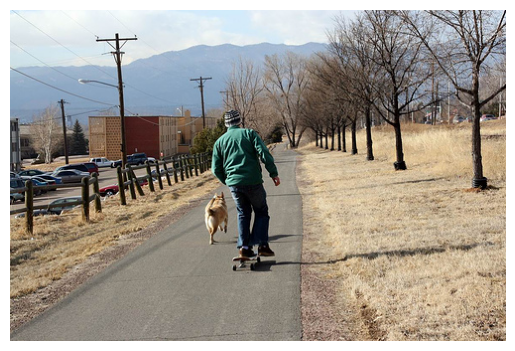

In [4]:
import skimage.io as io

img = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(img)
plt.show()

In [5]:
img.shape

(334, 500, 3)

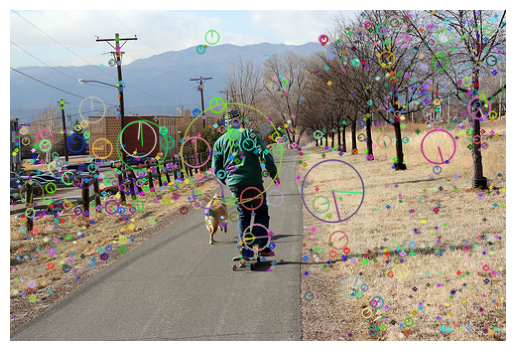

In [6]:
# attempt to use SIFT

import cv2

sift = cv2.SIFT_create()
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
kp, des = sift.detectAndCompute(img_gray, None)
img_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.axis('off')
plt.imshow(img_kp)
plt.show()

In [61]:
len(kp)

1135

---

even grid implementation

In [7]:
import numpy as np

def find_grid(hgt, wid, grid_spacing, patch_size):
    """
    Create a grid of upper-left patch corners.
    
    Parameters:
        hgt (int): Height of the image/grid.
        wid (int): Width of the image/grid.
        grid_spacing (int): Spacing between patches.
        patch_size (int): Size of the patch.
    
    Returns:
        grid_x (numpy.ndarray): X-coordinates of the grid.
        grid_y (numpy.ndarray): Y-coordinates of the grid.
    """
    rem_x = (wid - patch_size) % grid_spacing
    offset_x = (rem_x // 2) + 1
    rem_y = (hgt - patch_size) % grid_spacing
    offset_y = (rem_y // 2) + 1
    
    grid_x, grid_y = np.meshgrid(
        np.arange(offset_x, wid - patch_size + 1, grid_spacing),
        np.arange(offset_y, hgt - patch_size + 1, grid_spacing)
    )
    
    return grid_x, grid_y

In [8]:
patch_size = 64
grid_spacing = 32

grid_x, grid_y = find_grid(img.shape[0], img.shape[1], grid_spacing, patch_size)
grid_x, grid_y

(array([[ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427]]),
 array([[  8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
           8],
        [ 40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,
          40],
        [ 72,  72, 

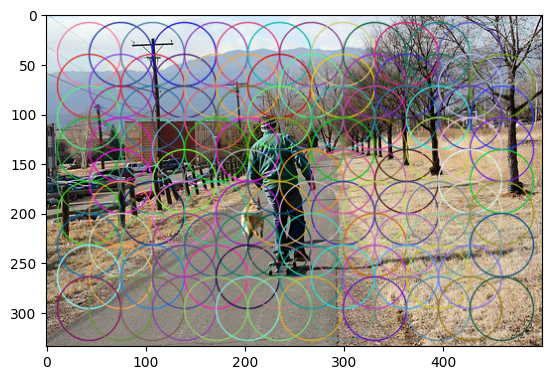

In [9]:
# define the keypoints from the grids
# we take the center of each grid as the keypoint coordinate

def generate_keypoints_from_grid(grid_x, grid_y):
    keypoints = []
    for i in range(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            keypoints.append(np.array([grid_x[i, j] + patch_size / 2.0, grid_y[i, j] + patch_size // 2.0]))
    return np.array(keypoints, dtype=np.float32)

keypoints = generate_keypoints_from_grid(grid_x, grid_y)
custom_keypoints = cv2.KeyPoint_convert(keypoints, size=patch_size, octave=0, class_id=-1)
plt.imshow(
    cv2.drawKeypoints(img, custom_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
)


In [10]:
def unpack_octave(octave):
    _octave = octave & 255
    layer = (octave >> 8) & 255
    _octave = _octave if _octave < 128 else (-128 | _octave)
    scale = 1.0 / (1 << _octave) if _octave >= 0 else float(1 << -_octave)
    
    return _octave, layer, scale

In [11]:
custom_keypoints[0].pt, custom_keypoints[0].size, custom_keypoints[0].angle, custom_keypoints[0].octave, custom_keypoints[0].response

((43.0, 40.0), 64.0, -1.0, 0, 1.0)

In [12]:
unpack_octave(custom_keypoints[0].octave)

(0, 0, 1.0)

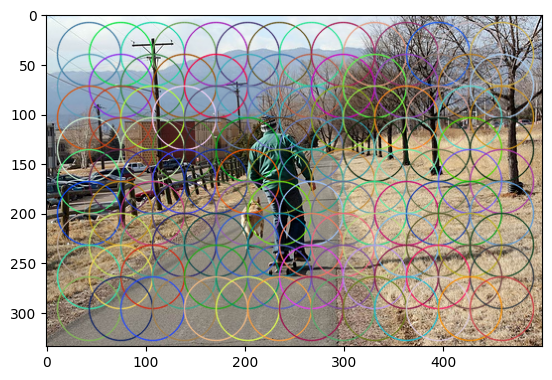

In [13]:
custom_keypoints_after, des_after = sift.compute(img, custom_keypoints)
plt.imshow(
    cv2.drawKeypoints(img, custom_keypoints_after, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
)
plt.show()

In [14]:
custom_keypoints_after[0].pt, custom_keypoints_after[0].size, custom_keypoints_after[0].angle, custom_keypoints_after[0].octave, custom_keypoints_after[0].response

((43.0, 40.0), 64.0, -1.0, 0, 1.0)

---

With reference to http://vision.stanford.edu/documents/Fei-FeiPerona2005.pdf

we implement the first way of extracting local regions

```code
Evenly Sampled Grid. An evenly sampled grid spaced at
10 × 10 pixels for a given image. The size of the patch is
randomly sampled between scale 10 to 30 pixels.
```

In [55]:
import numpy as np

MIN_PATCH_SIZE = 10
MAX_PATCH_SIZE = 30

def find_grid_random_size(hgt, wid, grid_spacing):
    """
    Create a grid of upper-left patch corners.
    
    Parameters:
        hgt (int): Height of the image/grid.
        wid (int): Width of the image/grid.
        grid_spacing (int): Spacing between patches.
    
    Returns:
        grid_x (numpy.ndarray): X-coordinates of the grid.
        grid_y (numpy.ndarray): Y-coordinates of the grid.
    """

    rem_x = (wid - MAX_PATCH_SIZE) % grid_spacing
    offset_x = (rem_x // 2) + 1
    rem_y = (hgt - MAX_PATCH_SIZE) % grid_spacing
    offset_y = (rem_y // 2) + 1
    
    grid_x, grid_y = np.meshgrid(
        np.arange(offset_x, wid - MIN_PATCH_SIZE + 1, grid_spacing),
        np.arange(offset_y, hgt - MIN_PATCH_SIZE + 1, grid_spacing)
    )
    
    return grid_x, grid_y

In [56]:
grid_spacing = 10

grid_x, grid_y = find_grid_random_size(img.shape[0], img.shape[1], grid_spacing)
grid_x, grid_y

(array([[  1,  11,  21, ..., 461, 471, 481],
        [  1,  11,  21, ..., 461, 471, 481],
        [  1,  11,  21, ..., 461, 471, 481],
        ...,
        [  1,  11,  21, ..., 461, 471, 481],
        [  1,  11,  21, ..., 461, 471, 481],
        [  1,  11,  21, ..., 461, 471, 481]]),
 array([[  3,   3,   3, ...,   3,   3,   3],
        [ 13,  13,  13, ...,  13,  13,  13],
        [ 23,  23,  23, ...,  23,  23,  23],
        ...,
        [303, 303, 303, ..., 303, 303, 303],
        [313, 313, 313, ..., 313, 313, 313],
        [323, 323, 323, ..., 323, 323, 323]]))

In [57]:
grid_x.shape

(33, 49)

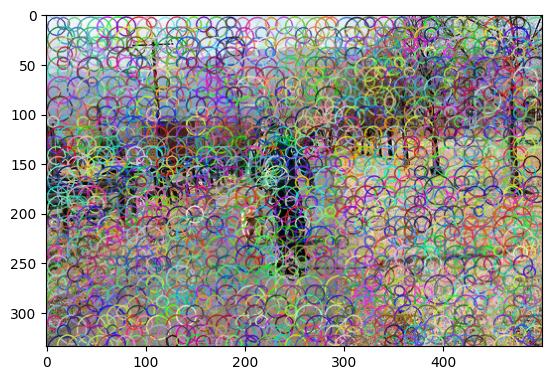

In [58]:
_seed = 20250321
np.random.seed(_seed)

def generate_keypoints_from_grid(grid_x, grid_y):
    keypoints = []
    for i in range(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            patch_size = np.random.randint(MIN_PATCH_SIZE, MAX_PATCH_SIZE + 1)

            keypoint_cv2 = cv2.KeyPoint(
                grid_x[i, j] + patch_size / 2.0,
                grid_y[i, j] + patch_size // 2.0,
                size=patch_size,
            )

            keypoints.append(keypoint_cv2)
    return keypoints

keypoints_cv2 = generate_keypoints_from_grid(grid_x, grid_y)

plt.imshow(
    cv2.drawKeypoints(img, keypoints_cv2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
)

In [54]:
keypoints.shape

(1617, 2)

---

Using pysift as the starting point

In [15]:
patch_size = 64
grid_spacing = 32

grid_x, grid_y = find_grid(img.shape[0], img.shape[1], grid_spacing, patch_size)
grid_x, grid_y

(array([[ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427],
        [ 11,  43,  75, 107, 139, 171, 203, 235, 267, 299, 331, 363, 395,
         427]]),
 array([[  8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
           8],
        [ 40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,
          40],
        [ 72,  72, 

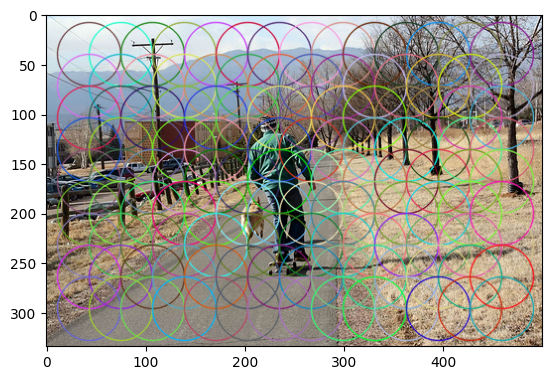

In [16]:
# define the keypoints from the grids
# we take the center of each grid as the keypoint coordinate

def generate_keypoints_from_grid(grid_x, grid_y):
    keypoints = []
    for i in range(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            keypoints.append(np.array([grid_x[i, j] + patch_size / 2.0, grid_y[i, j] + patch_size // 2.0]))
    return np.array(keypoints, dtype=np.float32)

keypoints = generate_keypoints_from_grid(grid_x, grid_y)
custom_keypoints = cv2.KeyPoint_convert(keypoints, size=patch_size, octave=0, class_id=-1)
plt.imshow(
    cv2.drawKeypoints(img, custom_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
)

In [17]:
# compute SIFT descriptors using custom keypoints and pysift implementation

import numpy as np
import cv2

import importlib
from PythonSIFT import pysift
importlib.reload(pysift)

import tqdm

def compute_descriptors_for_keypoints(image, keypoints, sigma=1.6, num_intervals=3, assumed_blur=0.5):
    """
    Compute SIFT descriptors for pre-defined keypoints using the pysift implementation.
    
    Args:
        image: Input image
        keypoints: List of cv2.KeyPoint objects with pre-defined positions and sizes
        sigma: Standard deviation of base Gaussian blur
        num_intervals: Number of intervals per octave
        assumed_blur: Assumed blur in the input image
        
    Returns:
        keypoints_with_orientations: The input keypoints with orientations assigned
        descriptors: SIFT descriptors for each keypoint
    """
    # Prepare the image and generate Gaussian pyramid
    image = image.astype('float32')
    base_image = pysift.generateBaseImage(image, sigma, assumed_blur)
    num_octaves = pysift.computeNumberOfOctaves(base_image.shape)
    gaussian_kernels = pysift.generateGaussianKernels(sigma, num_intervals)
    gaussian_images = pysift.generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    
    # Scale keypoints to the base image size (2x upsampled)
    scaled_keypoints = []
    for keypoint in keypoints:
        scaled_keypoint = cv2.KeyPoint(
            keypoint.pt[0] * 2, keypoint.pt[1] * 2,
            keypoint.size * 2, keypoint.angle, keypoint.response, keypoint.octave, keypoint.class_id
        )
        scaled_keypoints.append(scaled_keypoint)
    
    # Compute orientations for all keypoints
    keypoints_with_orientations = []
    # for keypoint in scaled_keypoints:
    for keypoint in tqdm(scaled_keypoints):
        # For all keypoints, compute orientation using the base octave
        octave_index = 0
        layer = 0  # First layer
        
        oriented_keypoints = pysift.computeKeypointsWithOrientations(
            keypoint, octave_index, gaussian_images[octave_index][layer]
        )
        keypoints_with_orientations.extend(oriented_keypoints)
    
    # Convert keypoints back to original image size
    for keypoint in keypoints_with_orientations:
        keypoint.pt = (keypoint.pt[0] * 0.5, keypoint.pt[1] * 0.5)
        keypoint.size *= 0.5
    
    # Compute descriptors
    descriptors = pysift.generateDescriptors(keypoints_with_orientations, gaussian_images)
    
    return keypoints_with_orientations, descriptors

ModuleNotFoundError: No module named 'PythonSIFT'

In [ ]:
keypoints_with_orientations, descriptors = compute_descriptors_for_keypoints(
    img_gray, custom_keypoints, sigma=1.6, num_intervals=3, assumed_blur=0.5
)

---

In [ ]:
# attempt to use SIFT on the grid
grid_kp = []
grid_des = []
for i in range(len(grid_x)):
    _kps = []
    _des = []
    for j in range(len(grid_x[0])):
        x = grid_x[i][j]
        y = grid_y[i][j]
        patch = img[y:y+32, x:x+32]
        kp, des = sift.detectAndCompute(patch, None)
        _kps.append(kp)
        _des.append(des)
    grid_kp.append(_kps)
    grid_des.append(_des)

# show the keypoints
img_kp = img.copy()
for i in range(len(grid_kp)):
    for j in range(len(grid_kp[i])):
        x = grid_x[i][j]
        y = grid_y[i][j]
        img_kp[y:y+32, x:x+32] = cv2.drawKeypoints(img[y:y+32, x:x+32], grid_kp[i][j], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.axis('off')
plt.imshow(img_kp)
plt.show()

---